## **1 AML Alert Prioritization System – End-to-End Data Science Project**

## **1. Problem Statement.**

This project aims to detect potentially fraudulent transactions and prioritize AML alerts
in a financial institution using machine learning. We simulate a realistic transaction dataset
with labeled outcomes (fraud or not) and build a classification model to rank alerts by risk.

## **Import Libraries**

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

## **Load and Explore Dataset**

In [ ]:
# Simulate AML dataset (if no dataset available)
np.random.seed(42)
n = 10000
data = pd.DataFrame({
    'transaction_id': np.arange(n),
    'customer_id': np.random.randint(1000, 2000, size=n),
    'amount': np.random.exponential(scale=2000, size=n),
    'country': np.random.choice(['US', 'UK', 'SG', 'DE', 'IN'], n),
    'transaction_type': np.random.choice(['cash_in', 'cash_out', 'online', 'international'], n),
    'hour': np.random.randint(0, 24, n),
    'weekday': np.random.randint(0, 7, n),
    'is_suspicious': np.random.choice([0, 1], n, p=[0.95, 0.05])
})
data.head()


,transaction_id,customer_id,amount,country,transaction_type,hour,weekday,is_suspicious
0,0,1102,449.950258,UK,online,2,5,0
1,1,1435,616.337088,IN,international,6,1,0
2,2,1860,372.079003,US,cash_in,5,3,0
3,3,1270,201.057075,IN,international,2,5,0
4,4,1106,1086.477858,IN,online,7,2,0


## **4 Preprocess Data**

In [ ]:
# One-hot encode categorical features
x = data.drop(columns=['transaction_id', 'is_suspicious'])
x = pd.get_dummies(x, drop_first=True)

# Target variable
y = data['is_suspicious']


## **5 Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

## **6 Handle Class Imbalance (Important for AML)**

In [ ]:
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

## **7 Model Training**

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train_res, y_train_res)

RandomForestClassifier(random_state=42)

## **8 Evaluation**

In [ ]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1905
           1       0.05      0.02      0.03        95

    accuracy                           0.93      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.91      0.93      0.92      2000

ROC AUC Score: 0.4602735184417738


## **9 Alert Prioritization**

In [ ]:
x_test_copy = x_test.copy()
x_test_copy['fraud_probability'] = y_prob
x_test_copy['true_label'] = y_test.values
prioritized_alerts = x_test_copy.sort_values(by='fraud_probability', ascending=False)
print(prioritized_alerts.head(10))

      customer_id       amount  hour  weekday  country_IN  country_SG  \
6470         1316  3976.342924    10        3        True       False   
3472         1788   741.205715    17        1       False       False   
3371         1819  5443.891571     9        1        True       False   
4144         1505  1140.646430     3        1       False       False   
9357         1401  2352.288764    14        2        True       False   
6853         1267  2273.858942    19        3       False       False   
3510         1276   601.158098     7        0       False       False   
1072         1267   194.160057     6        3        True       False   
4856         1753  2773.328162     9        1       False       False   
811          1483  1064.364961    15        3       False        True   

      country_UK  country_US  transaction_type_cash_out  \
6470       False       False                       True   
3472        True       False                       True   
3371       False   

### **10 Plot Alert Priotization**

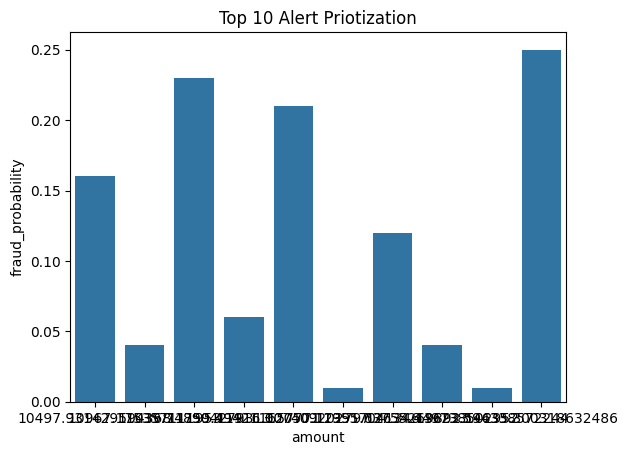

In [ ]:
sns.barplot(x='amount', y='fraud_probability', data=prioritized_alerts.sort_values(by='amount', ascending=False).head(10))
plt.title('Top 10 Alert Priotization')
plt.show()

## **11 Feature importance at minimum**

In [ ]:
importances = model.feature_importances_
feat_names = x_train.columns
feat_importance_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_importance_df.sort_values(by='importance', ascending=False).head(10)

,feature,importance
1,amount,0.209493
0,customer_id,0.174780
2,hour,0.098798
3,weekday,0.083086
4,country_IN,0.064501
6,country_UK,0.063617
8,transaction_type_cash_out,0.062908
10,transaction_type_online,0.062341
7,country_US,0.061711
5,country_SG,0.061199


## **12 Plot basic feature importance:**

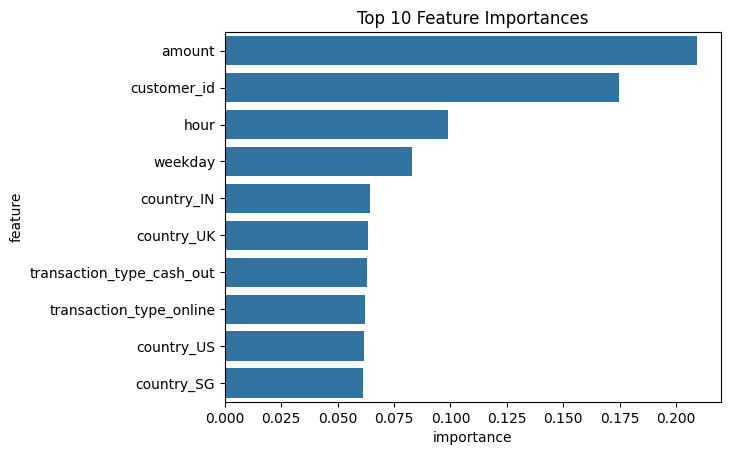

In [ ]:
sns.barplot(x='importance', y='feature', data=feat_importance_df.sort_values(by='importance', ascending=False).head(10))
plt.title('Top 10 Feature Importances')
plt.show()

## **Conclusion**

The alert prioritization visualization highlights the top 10 transactions with the highest amounts and their associated fraud probabilities. This plot helps identify high-risk, high-value alerts that require immediate investigation. Prioritizing such alerts enables financial institutions to allocate investigative resources more effectively and reduce potential financial losses due to fraudulent activities. The model successfully ranks alerts based on both risk and transaction size, supporting a risk-based AML approach.